# Land Cover classification with U-Net (multi-class semantic segmentation)

## Table of Content

- [Packages](#1)
- [Load dataset](#2)
- [Dataset description](#3)
- [Preprocessing](#4)
- [Class distribution of the training data](#5)
- [Model](#6)
- [Confusion matrix](#7)

<a name='1'></a>
### Load packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import imageio
import os
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore", category=DeprecationWarning)
path = 'C:/Users/USER/OneDrive/Desktop/Satellite Image Segmentation/Project'
os.chdir(path)
from src.utils import get_image_mask_list, sort_image_mask_lists, display_image_mask
from src.preprocessing import preprocess_pipeline, split, Augment, modify_mask, one_hot

<a name='2'></a>
## Load dataset

In [2]:
# Different project path
path = 'C:/Users/USER/OneDrive/Desktop/Segmantation_project/pythonProject/data/raw'
os.chdir(path)

image_list, mask_list = get_image_mask_list(path)
image_list_sorted, mask_list_sorted = sort_image_mask_lists(image_list, mask_list)

Text(0.5, 1.0, 'Segmentation')

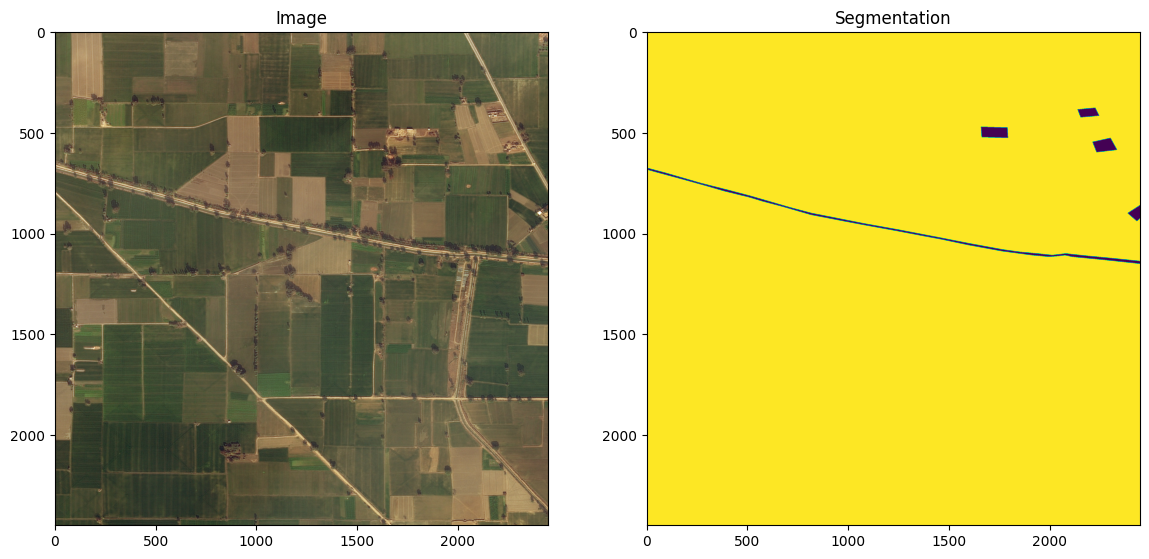

In [3]:
# Visualize example of image and mask
ind = 2
img = imageio.imread(image_list_sorted[ind])
mask = imageio.imread(mask_list_sorted[ind])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

<a name='3'></a>
### Dataset description
The dataset consists of 803 satellite images and the corresponding masks (lables). The lables defined as follows:

In [4]:
data = {
    'r': [0, 255, 255, 0, 0, 255, 0],
    'g': [255, 255, 0, 255, 0, 255, 0],
    'b': [255, 0, 255, 0, 255, 255, 0],
    'Color': ['Cyan', 'Yellow', 'Magenta', 'Green', 'Blue', 'White', 'Black'],
}

titles = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land',
          'water', 'barren_land', 'unknown']

df = pd.DataFrame(data, index=titles)

# Function to calculate luminance
def calculate_luminance(r, g, b):
    return 0.299 * r + 0.587 * g + 0.114 * b

# Custom function to set the background and text color based on RGB values
def highlight_row(row):
    r, g, b = row['r'], row['g'], row['b']
    hex_color = f'#{r:02x}{g:02x}{b:02x}'

    luminance = calculate_luminance(r, g, b)
    text_color = 'black' if luminance > 128 else 'white'

    return [f'background-color: {hex_color}; color: {text_color}'] * len(row)

styled_df = df.style.apply(highlight_row, axis=1) \
    .set_properties(**{'text-align': 'center', 'font-size': '12pt',
                       'width': '80px'}) \
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '14pt'), ('text-align',
                                                             'center')]},
        {'selector': 'td:hover', 'props': [('background-color', '#ffff99')]},
    ])

styled_df

,r,g,b,Color
urban_land,0,255,255,Cyan
agriculture_land,255,255,0,Yellow
rangeland,255,0,255,Magenta
forest_land,0,255,0,Green
water,0,0,255,Blue
barren_land,255,255,255,White
unknown,0,0,0,Black


<a name='4'></a>
## Preprocessing

In [5]:
"""
dataset = create_shuffled_dataset(image_list_sorted, mask_list_sorted)
"""

In [6]:
"""
# Define the new size of the image (height and witdh)
#size = 256
"""

In [5]:
# Apply preprocessing
processed_image_ds = preprocess_pipeline(image_list, mask_list, divide=False)

In [6]:
train_dataset, val_dataset, test_dataset, train_size, val_size = split(train_frac=0.8, val_frac=0.1, dataset=processed_image_ds)

In [7]:
# Increase the size of the training dataset using data augmentation
tf.random.set_seed(1234)

size=256
num = 5
crop_height, crop_width, target_height, target_width = 96, 96, size, size 

train_dataset_augmented = train_dataset

for _ in range(num):
    seed = int((tf.random.uniform(shape=(), minval=0,
                             maxval=1000, dtype=tf.int32).numpy()))
    augmented_dataset = train_dataset.map(Augment(seed, crop_height, crop_width, target_height, target_width))
    train_dataset_augmented = train_dataset_augmented.concatenate(augmented_dataset)

In [8]:
train_dataset_augmented = train_dataset_augmented.map(modify_mask).map(one_hot)
val_dataset = val_dataset.map(modify_mask).map(one_hot)
test_dataset = test_dataset.map(modify_mask).map(one_hot)

In [10]:
"""
train_dataset_augmented = train_dataset_augmented.map(lambda image, mask: modify_mask(image, mask, size))
val_dataset = val_dataset.map(lambda image, mask: modify_mask(image, mask, size))
test_dataset = test_dataset.map(lambda image, mask: modify_mask(image, mask, size))
"""

In [ ]:
dist = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}

for img, mask in train_dataset:
    mask_numpy = mask.numpy().squeeze()
    unique_values, counts = np.unique(mask_numpy, return_counts=True)
    for val, count in zip(unique_values, counts):
        dist[val] += count

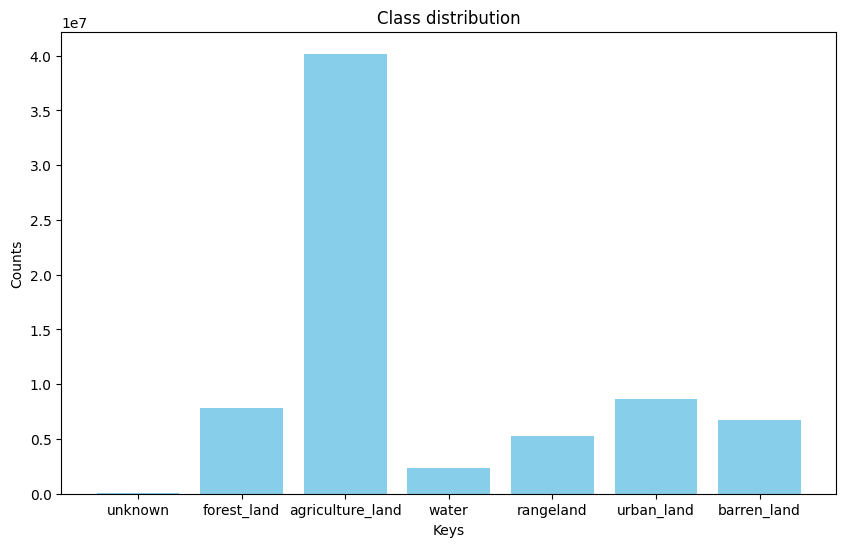

In [11]:
dist = {0: 28935, 1: 7847629, 2: 40193490,
        3: 2319086, 4: 5270606, 5: 8637840, 6: 6677902}

classes = {0: 'unknown', 1:'forest_land', 2:'agriculture_land', 3:'water',
           4:'rangeland', 5:'urban_land', 6:'barren_land'}

keys = list(dist.keys())
values = list(dist.values())

# Map keys to class names
keys = [classes[key] for key in keys]

plt.figure(figsize=(10, 6))

plt.bar(keys, values, color='skyblue')

plt.xlabel('Keys')
plt.ylabel('Counts')
plt.title('Class distribution')

plt.show()

In [9]:
train_dataset_augmented = train_dataset_augmented.cache().prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(tf.data.AUTOTUNE)

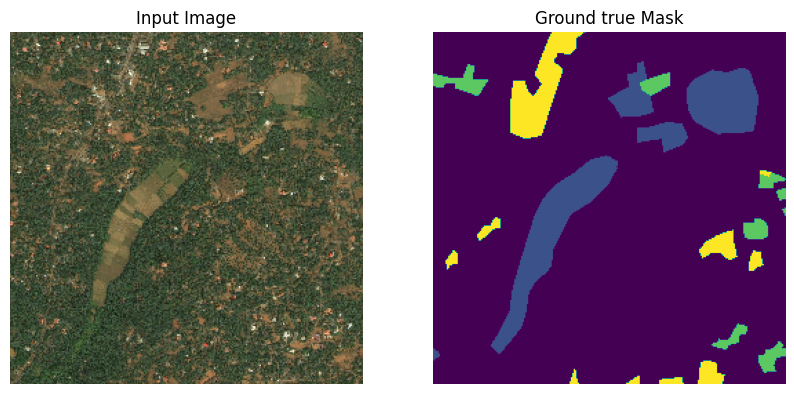

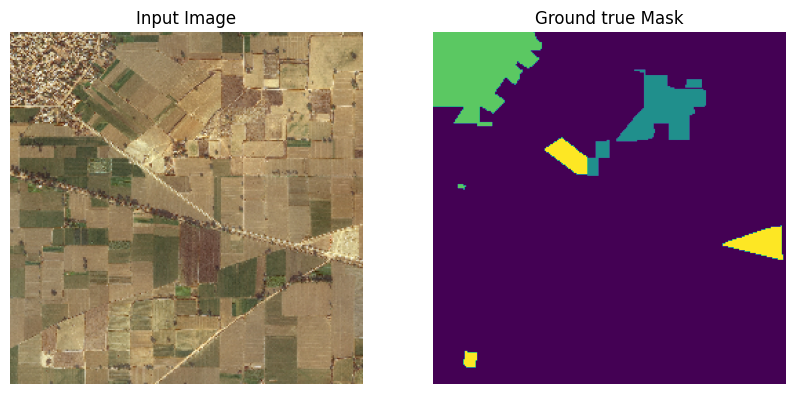

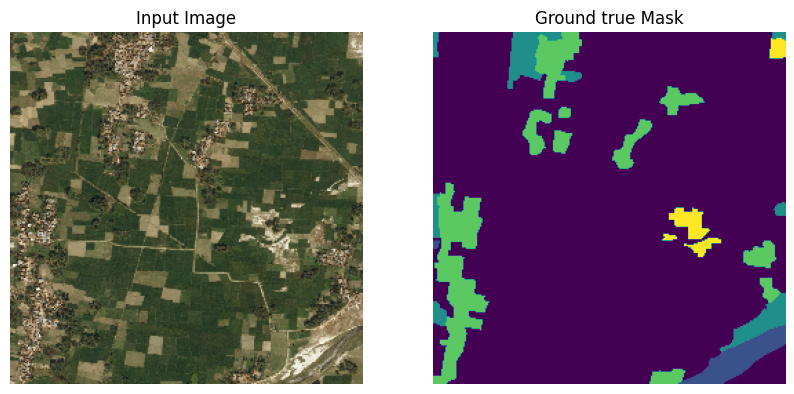

In [10]:
# Show several examples of the training data after preprocessing
for image, mask in train_dataset_augmented.take(3):
    sample_image, sample_mask = image, mask
    sample_mask = tf.argmax(sample_mask, axis=-1).numpy().reshape(size,size,1)
    display_image_mask([sample_image, sample_mask])

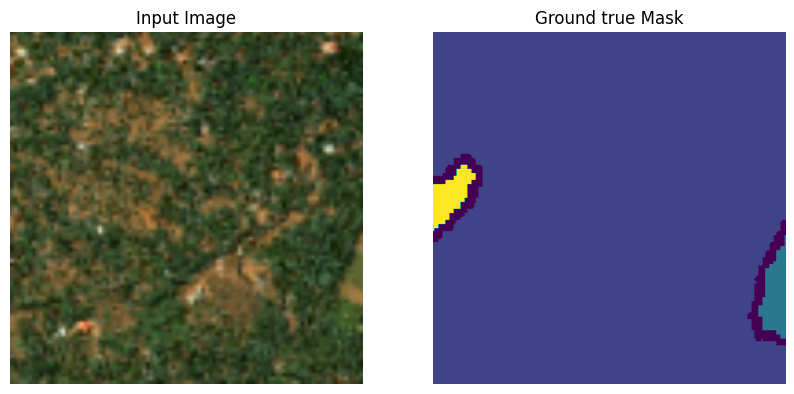

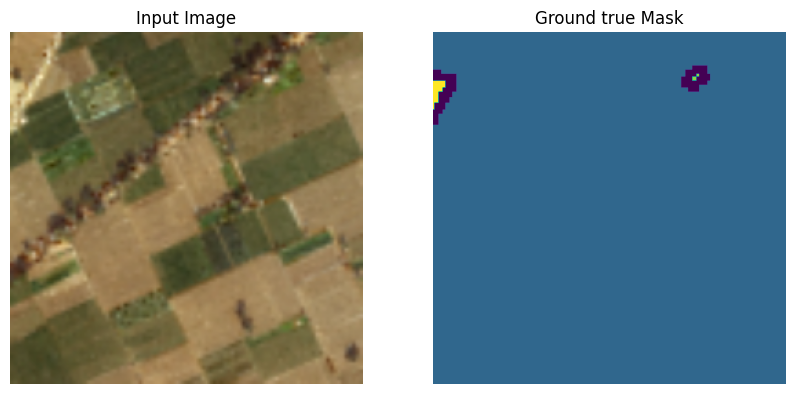

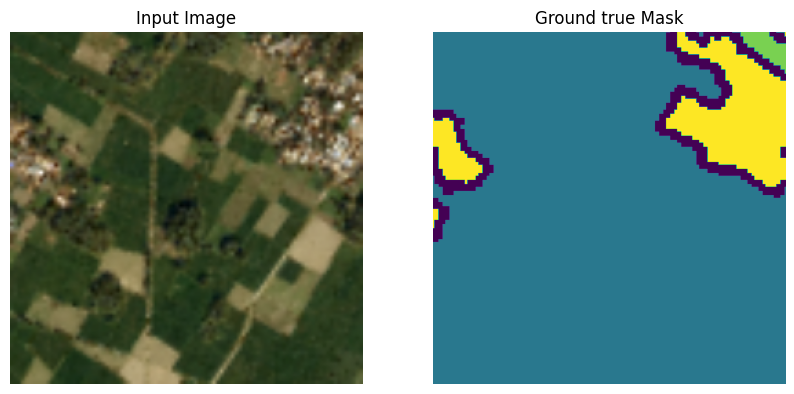

In [12]:
# Show augmented images and masks
for image, mask in train_dataset_augmented.skip(train_size).take(3):
    sample_image, sample_mask = image, mask
    sample_mask = tf.argmax(sample_mask, axis=-1).numpy().reshape(size,size,1)
    display_image_mask([sample_image, sample_mask])

In [13]:
BUFFER_SIZE = 500

train_dataset_augmented = train_dataset_augmented.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE)

In [14]:
data_dir = 'C:/Users/USER/OneDrive/Desktop/Segmantation_project/pythonProject/data/processed'

train_subdir = f'{data_dir}/train'
val_subdir = f'{data_dir}/val'
test_subdir = f'{data_dir}/test'

tf.data.Dataset.save(train_dataset_augmented, train_subdir)
tf.data.Dataset.save(val_dataset, val_subdir)
tf.data.Dataset.save(test_dataset, test_subdir)